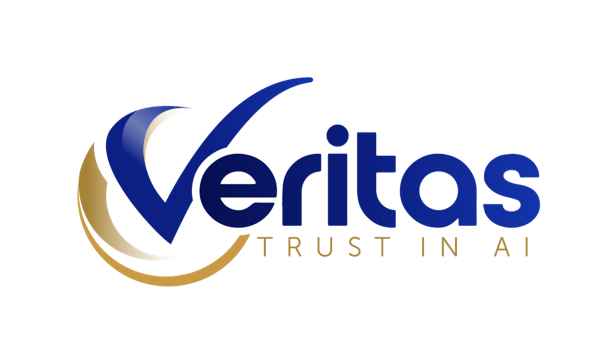

# Veritas Diagnosis Tool Demo : New Use Case Creation
    
<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a new use case and use diagnosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness & transparency assessment report.
</p>    
<p>        
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Set up New Use Case <br/>
    3. Fairness & Transparency Diagnosis <br/>
</p>

# 1. Loading Data and Model

## Importing Libraries 

In [8]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path
# making veritas available in search path
sys.path.append('../../')
from sklearn.metrics import accuracy_score
import os
sys.path.insert(0, os.getcwd().split('veritastool\\examples')[0])
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data 

In [9]:
pth = os.path.abspath('.')

#Load Credit Scoring Test Data
file = os.path.join(pth, 'data',"clv_dict.pickle") 
input_file = open(file, "rb")
clv = pickle.load(input_file)

#Model Contariner Parameters
y_true = np.array(clv["y_test"])
y_pred = np.array(clv["y_pred"])
x_test = clv["x_test"]
y_prob = pd.DataFrame(clv['y_prob'], columns=[0, 1, 2])
y_train = np.array(clv["y_train"])
x_train = clv["x_train"]

p_grp = {'Country': 'maj_rest'}

## Data Exploration

In [10]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0],x_train.shape[1]))
x_train.head()

No of rows: 2105 
No. of columns: 9


,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,Segment,Country
0,-1.031193,3,2.876925,2,1.443396,0,2.125558,0,29
1,2.289436,0,-0.437318,0,-0.221031,0,-1.709475,1,29
2,1.637441,0,-0.437318,0,-0.143641,0,-1.709475,1,29
3,-1.076681,3,1.035679,1,0.026995,0,1.358551,2,29
4,-1.167658,3,-0.437318,0,-0.140523,0,0.591544,2,29


## Loading Model 

In [11]:
model = clv["model"]
model_name = "cstmr_lifetime_val"
model_type = "classification"

In [12]:
# from sklearn.ensemble import GradientBoostingClassifier

In [13]:
# model = GradientBoostingClassifier()
# model.fit(x_train, y_train)

In [14]:
y_pred = model.predict(x_test)
print("Accuracy: {}".format(round(accuracy_score(y_true,y_pred),3)))

Accuracy: 0.821


# 2. Set up new Use Case 

<p>        
    Veritas Library new use case creation includes four steps. <br/>
    <ol>
    <li> principle classes Fairness and Transparency and input validation utility functions are imported.</li>  
    <li> use case object class inheriting from principle classes is defined with model_type, metric_group, expected label size and expected model count information. </li>  
    <li> init function is defined with inputs expected by principle classes and other use case specific inputs.</li>  
    <li> required attributes and input validation checks are also defined and called respectively in the init function</li>  
    </ol>
</p>

In [15]:
from veritastool.principles import Fairness, Transparency
from veritastool.util.utility import check_datatype, check_value

In [16]:
class CustomerLifetimeValue(Fairness,Transparency):
    
    _model_type_to_metric_lookup = {"classification": ("classification", 3, 1)}
    
    def __init__(self, model_params, fair_threshold, perf_metric_name = "balanced_acc", fair_metric_name = "auto", \
                 fair_concern = "eligible", fair_priority = "benefit", fair_impact = "normal", fair_metric_type = 'difference',\
                 num_applicants = None, base_default_rate = None, fairness_metric_value_input = {}, tran_index = [1], \
                 tran_max_sample = 1, tran_pdp_feature = [], tran_pdp_target=None, tran_max_display = 10):
        
        fair_is_pos_label_fav = True
        Fairness.__init__(self,model_params, fair_threshold, fair_metric_name, fair_is_pos_label_fav, fair_concern, \
                          fair_priority, fair_impact, fair_metric_type, fairness_metric_value_input)               
        Transparency.__init__(self, tran_index, tran_max_sample, tran_pdp_feature, tran_pdp_target, tran_max_display)
        
        self.perf_metric_name = perf_metric_name
        self._set_up_fairness()
        self._model_data_processing()
        self._tran_check_input()
        
        
    

# 3. Fairness & Transparency Diagnosis

## Import Veritas Library

In [17]:
from veritastool.model.modelwrapper import ModelWrapper
from veritastool.model.model_container import ModelContainer

## Initializing Veritas Diganosis Library

In [18]:
#Create Model Container 
container = ModelContainer(y_true, p_grp, model_type, model_name, y_pred, y_prob, y_train, x_train=x_train, \
                           x_test=x_test, model_object=model)


<h5 align="center">Table 1: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |No|
| x_train     | data           | training      | train set features |-      |No|
| p_grp       | protected vars |    -          | list of privileged groups| { 'SEX': [ 1 ] , 'MARRIAGE': [ 1 ] }   |Yes|
| up_grp       | protected vars |    -          | list of unprivileged groups| { 'SEX': [ 2 ] , 'MARRIAGE': [ 2 ] }   |No|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'credit'    |Yes|
| model_name  | model          |    -          | name of model | 'credit scoring'   |No|


In [19]:
#Create Use Case Object
new_use_case_obj= CustomerLifetimeValue(model_params = [container], fair_threshold = 80, fair_concern = "eligible", \
                           fair_priority = "benefit", fair_impact = "normal", tran_index=[20,40], tran_max_sample = 100, tran_max_display = 11)


<h5 align="center">Table 2: Credit Scoring parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_metric_name| metric name |primary fairness metric | "auto" or any of supported ones <br/> like "equal_opportunity" |No|
| perf_metric_name      | metric name |primary performance metric |"balanced_acc"   |No|
| fair_concern | fair_metric selection | most concerned cohort |"eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection|top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection |impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_metric_type  | fair_metric selection | type of metric | "difference" or "ratio"  |No|
| fair_threshold | fairness metric thresolding |threshold used for assessment|actual value [0,1] or p% rule (1,100]|Yes|
| tran_index      | transparency parameter |index for local interpretability plot |list of integers   |No|
| tran_max_sample      | transparency parameter |sampling size for transparency analysis |float value between 0 and 1 (treated as <br/> percentage of rows)  or  int treated as #rows   |No|
| tran_pdp_feature      | transparency parameter |feature list for pdp plots |list of features   |No|
| tran_pdp_target      | transparency parameter |class label for pdp plots(required for uplift model) |string |No|
| tran_max_display      | transparency parameter |#features to be displayed in the transparency plots |int    |No|



## Starting Fairness diagnosis

In [20]:
new_use_case_obj.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                          16.859%
	neg_label                                                          83.141%


Performance Metrics
	Selection Rate                                             0.127 +/- 0.019
	Accuracy                                                   0.839 +/- 0.024
	Balanced Accuracy                                          0.664 +/- 0.033
	Recall                                                     0.400 +/- 0.063
	Precision                                                  0.530 +/- 0.078
	F1 Score                                                   0.456 +/- 0.061
	True Negative Rate                                         0.928 +/- 0.016
	False Negative Rate                                        0.600 +/- 0.063
	Negative Predictive Value                                  0.884 +/- 0.022
	ROC AUC Score                                              0.814 +/- 0.029
	Log-loss                                     

## Starting Transparency Diagnosis

Running transparency for model 1                  


Exact explainer: 103it [00:10,  1.59it/s]                                                                              

     Data preparation                   done      


Computing Permutation Importance:   0%|          

     Global interpretability            done      
     Partial dependence analysis        done      
     Local interpretability             done      


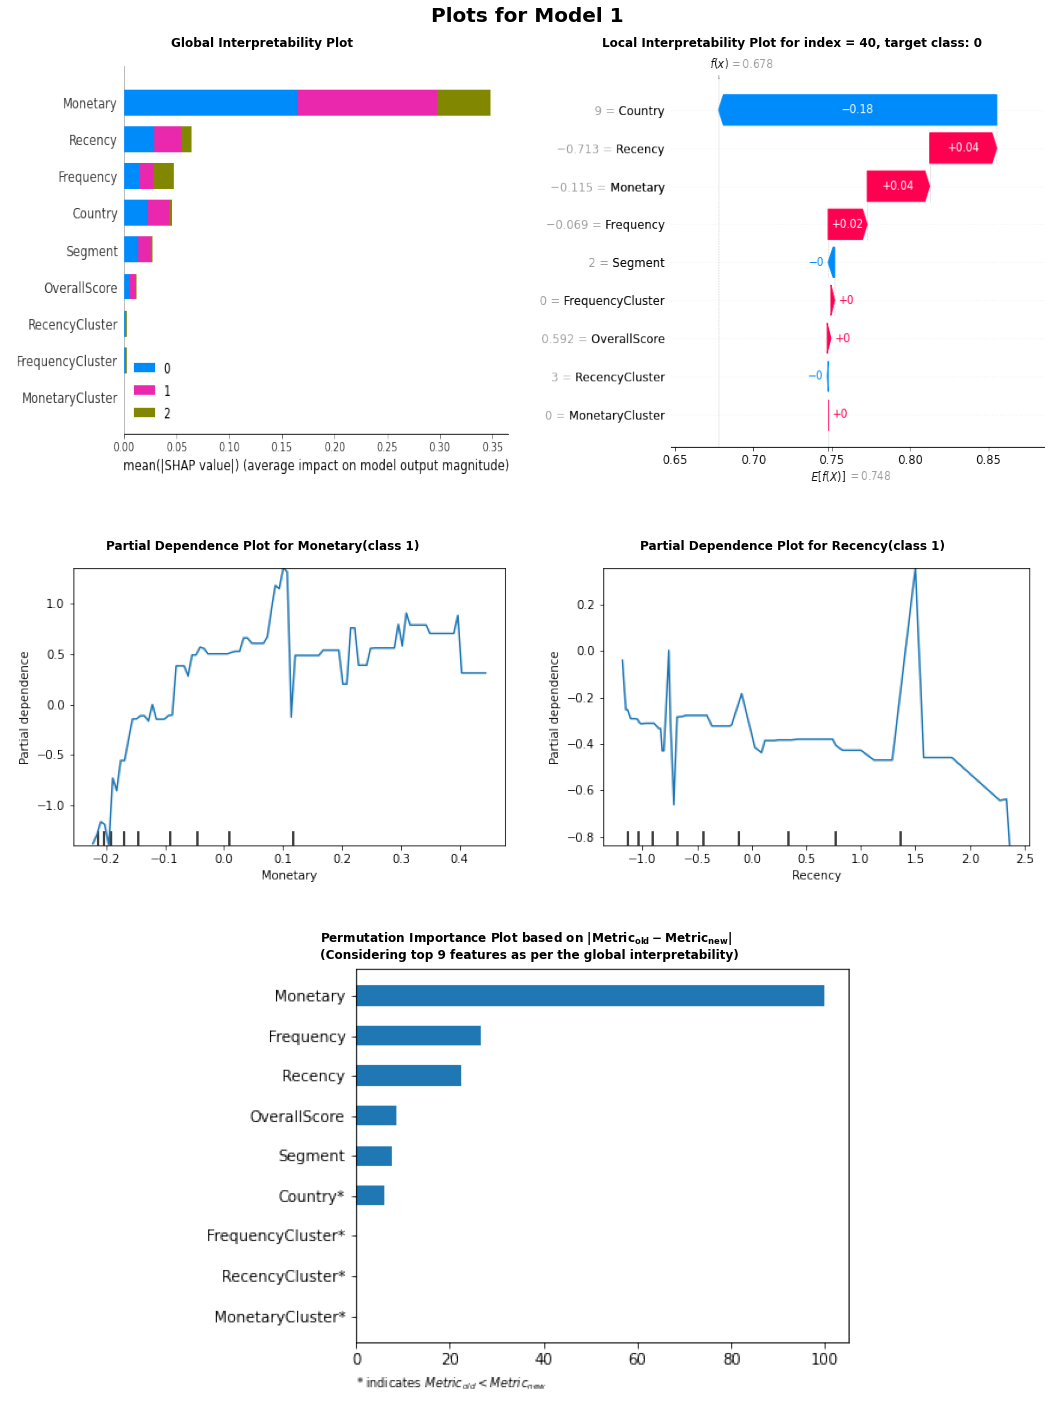

In [21]:
#run the entire transparency analysis for the last available model
new_use_case_obj.explain()

<h5 align="center">Table 3: Transparency parameters   </h5>

| Var Name    | Description   |  Value        |Default|Compulsory|
| :---        |          ---: |          ---: |---:|---:|
| local_index |index for local interpretability plot |integer   |last value of tran_index |No|
| model_num   |model for which assessment is required |1 or 2   |last model in model container |No|
| output      |boolean value for displaying the plots |True or False   |True |No|





## Compiling Results

In [ ]:
new_use_case_obj.compile()